# Setup

In [104]:

import os
import sys
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast
from scipy.stats import linregress

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

# Processing

In [36]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """
    
    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        try:
            print("Starting model: ", model)
            # Load data
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)
            continue

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP5"] #, "CMIP5"]
    variables = ["tos"] # ,"rsutcs", "rsut"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=False,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)
            if calc_anoms:
                ds.to_netcdf(f"/data/{var}_mon_1850-2100_anoms_{era}_piControl.nc")
            else: 
                ds.to_netcdf(f"/data/{var}_mon_1850-2100_{era}_piControl.nc")
                

        break

collect_data()

Starting era:  CMIP5
Starting variable:  tos
Starting model:  CNRM-CM5
Starting model:  bcc-csm1-1
Starting model:  bcc-csm1-1-m
Starting model:  GFDL-ESM2G
Starting model:  GFDL-ESM2M
Starting model:  GFDL-CM3
Starting model:  EC-EARTH
Starting model:  CESM1-WACCM
Starting model:  CESM1-CAM5
Starting model:  CESM1-FASTCHEM
Starting model:  CESM1-BGC
Starting model:  IPSL-CM5B-LR
Starting model:  IPSL-CM5A-MR
Starting model:  IPSL-CM5A-LR
Starting model:  HadGEM2-ES
Starting model:  HadGEM2-CC
Starting model:  ACCESS1-3
Starting model:  ACCESS1-0
Starting model:  HadGEM2-AO
Starting model:  GISS-E2-H
Starting model:  GISS-E2-R
Starting model:  GISS-E2-R-CC
Starting model:  GISS-E2-H-CC
Starting model:  CSIRO-Mk3-6-0
Starting model:  CanESM2
Starting model:  inmcm4
Starting model:  CMCC-CMS
Starting model:  CMCC-CM
Starting model:  CMCC-CESM
Starting model:  MIROC5
Starting model:  NorESM1-ME
Starting model:  NorESM1-M
Starting model:  MPI-ESM-MR
Starting model:  MPI-ESM-P
Starting mode

In [33]:
def calculate_swcre(rsutcs: xr.Dataset, rsut: xr.Dataset, save: bool = False, save_name: str = "") -> Tuple[xr.Dataset, xr.Dataset]:
    """
    Calculates the shortwave cloud radiative effect as the difference between the TOA SW clear-sky flux and the TOA SW all-sky flux

    swcre = rsutcs - rsut
    swcre_anoms = swcre - swcre_climatology

    Args:
        rsutcs (xr.Dataset): TOA clear-sky upward SW flux
        rsut (xr.Dataset): TOA all-sky upward SW flux
        save (bool, optional): Defaults to False
        save_name (str, optional): Defaults to "".

    Returns:
        swcre (xr.Dataset): dimensions (model, time, lat, lon)
        swcre anoms (xr.Dataset): dimensions (model, time, lat, lon)
    """
    if not save: 
        print(f"Loading {save_name}")
        swcre = xc.open_dataset(f"data/swcre{save_name}_monthly_1850-2000.nc", chunks="auto")
        swcre_anoms = xc.open_dataset(f"data/swcre{save_name}_anoms_monthly_1850-2000.nc", chunks="auto")
        return swcre, swcre_anoms 

    else:
        # Select common models
        common_models = list(set(rsutcs["model"].values) & set(rsut["model"].values))
        rsutcs = rsutcs.sel(model=common_models)
        rsut = rsut.sel(model=common_models)
        # Calculate SWCRE
        swcre = rsutcs["rsutcs"] - rsut["rsut"]
        swcre = swcre.rename("swcre").to_dataset()
        # Set time bounds
        swcre["time_bnds"] = rsut["time_bnds"]
        # Calculate SWCRE anomalies
        swcre_anoms = swcre.temporal.departures("swcre", "month")
        swcre_anoms = swcre_anoms.rename({"swcre": "swcre_anoms"})

        print("Saving data")
        swcre.to_netcdf(f"data/swcre{save_name}_monthly_1850-2000.nc")
        swcre_anoms.to_netcdf(f"data/swcre{save_name}_anoms_monthly_1850-2000.nc")

    return swcre, swcre_anoms

# Set save or load
SAVE = False

if SAVE: 
    # Load data
    rsut_cmip5 = xc.open_dataset("data/rsut_mon_1850-2100_CMIP5_piControl.nc")
    rsut_cmip6 = xc.open_dataset("data/rsut_mon_1850-2100_CMIP6_piControl.nc")
    rsutcs_cmip6 = xc.open_dataset("data/rsutcs_mon_1850-2100_CMIP6_piControl.nc")
    rsutcs_cmip5 = xc.open_dataset("data/rsutcs_mon_1850-2100_CMIP5_piControl.nc")
else:
    # Filler Data
    rsut_cmip5, rsut_cmip6, rsutcs_cmip5, rsutcs_cmip6 = None, None, None, None

# Calculate SWCRE, SWCRE anomalies, and save
swcre_cmip6, swcre_anoms_cmip6 = calculate_swcre(rsutcs_cmip6, rsut_cmip6, save=SAVE, save_name="_cmip6")
swcre_cmip5, swcre_anoms_cmip5 = calculate_swcre(rsutcs_cmip5, rsut_cmip5, save=SAVE, save_name="_cmip5")


Loading _cmip6
Loading _cmip5


In [34]:
def calculate_swcf(tos: xr.Dataset, swcre: xr.Dataset, save: bool = False, save_name: str = "") -> xr.Dataset:
    """Calculate the shortwave cloud feedback (swcf)

    Definition 1:
    swcf = dR_swcre / dSST (Wm^-2/K)

    Definition 2:
    swcre_anoms = swcf * SST_anoms + b

    Args:
        tos (xr.Dataset): monthly sst anomalies
        swcre (xr.Dataset): monthly swcre anomalies
        save (bool, optional): Defaults to False.
        save_name (str, optional): Defaults to "".

    Returns:
        swcf (xr.Dataset): dimensions (model, time, lat, lon)
    """
    if save: 
        # Rechunk along time dimension
        tos = tos.chunk({'time': -1})
        swcre = swcre.chunk({'time': -1})

        # Calculate the correlation coefficient
        swcf = xscore.linslope(tos, swcre, dim='time', skipna=True)
        swcf.to_netcdf(f"data/swcf_{save_name}_monthly_1850-2000.nc")
    else: 
        swcf = xr.open_dataarray(f"data/swcf_{save_name}_monthly_1850-2000.nc", chunks="auto")
    return swcf

# Set save or load
SAVE = True
# Load tos
tos_cmip6 = xc.open_dataset("data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto")
tos_cmip5 = xc.open_dataset("data/tos_mon_1850-2100_CMIP5_piControl.nc", chunks="auto") - 273.15 # Convert Kelvin to Celsius
# Calculate tos anomalies
tos_anoms_cmip6 = tos_cmip6.temporal.departures("tos", "month")
tos_anoms_cmip5 = tos_cmip5.temporal.departures("tos", "month")

In [165]:
def global_plot(data, lon, lat, cmap, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        # levels=np.arange(-4, 4.1, 0.1)
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.show()
    
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12) -> np.array:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    grads = np.zeros((data.model.size, int((len(data.time) - window) / step)))
    grads.fill(np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        grads[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values

    # Convert to xarray
    return xr.DataArray(grads*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(grads.shape[1])})

def get_east_west(ds: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    return (
        ds.sel(lon=slice(130, 180), lat=slice(-7, 7)), # West pacific
        ds.sel(lon=slice(-130, -80), lat=slice(-7, 7)) # East pacific
    )

def calculate_west_east_gradient(ds: xr.Dataset, var: str) -> Tuple[xr.DataArray, xr.DataArray, xr.DataArray]:
    ds = xc.swap_lon_axis(ds, to=(-180, 180))

    ds_west, ds_east = get_east_west(ds)

    ds_west = ds_west.spatial.average(var)[var]
    ds_east = ds_east.spatial.average(var)[var]

    # Calculate gradient
    return ds_west, ds_east, ds_west - ds_east

def to_pickle(obj: Any, path: str):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def from_pickle(path: str) -> Any:
    with open(path, 'rb') as file:
        return pickle.load(file)


# Shortwave Cloud Feedback Calculations and Sanity Check

In [98]:
SAVE = False 

# Calculate SWCF
swcf_cmip6 = calculate_swcf(tos_anoms_cmip6["tos"], swcre_anoms_cmip6["swcre_anoms"], save=SAVE, save_name="cmip6")
swcf_cmip5 = calculate_swcf(tos_anoms_cmip5["tos"], swcre_anoms_cmip5["swcre_anoms"], save=SAVE, save_name="cmip5")

def get_swcf_regions(ds, var="swcf", save=True, save_name="cmip6"):
    # Prep dataset
    ds = ds.rename("swcf").to_dataset().bounds.add_bounds("X")
    ds = ds.bounds.add_bounds("Y")
    ds = xc.swap_lon_axis(ds, to=(-180, 180))

    # West Pacific
    ds_west = ds.sel(lon=slice(130, 180), lat=slice(-7, 7))
    ds_west = ds_west.spatial.average(var)[var]
    # East Pacific
    ds_east = ds.sel(lon=slice(-130, -80), lat=slice(-7, 7))
    ds_east = ds_east.spatial.average(var)[var]
    # East Pacific South America
    ds_east_sa = ds.sel(lons=(-105, -75), lats=(-50, -20))
    ds_east_sa = ds_east_sa.spatial.average(var)[var]
    # Global Mean
    ds_global = ds.spatial.average(var)[var]

    # Save to netcdf
    if save: 
       ds_east.to_netcdf(f"data/swcf_east_{save_name}.nc") 
       ds_west.to_netcdf(f"data/swcf_west_{save_name}.nc")
       ds_east_sa.to_netcdf(f"data/swcf_east_sa_{save_name}.nc")
       ds_global.to_netcdf(f"data/swcf_global_{save_name}.nc")

    return ds_west, ds_east, ds_east_sa, ds_global

swcf_west_cmip6, swcf_east_cmip6, swcf_eastsa_cmip6, swcf_global = get_swcf_regions(ds=swcf_cmip6, var="swcf", save=SAVE, save_name="cmip6")
swcf_west_cmip5, swcf_east_cmip5, swcf_eastsa_cmip5, swcf_global = get_swcf_regions(ds=swcf_cmip5, var="swcf", save=SAVE, save_name="cmip5")

2023-06-19 16:40:02,007 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-06-19 16:40:02,025 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


In [185]:
global_plot(lon=swcf_cmip6.lon, lat=swcf_cmip6.lat, data=swcf_cmip6.mean(["model"], skipna=True), cmap="RdBu_r", title="CMIP6 SWCF")
global_plot(lon=swcf_cmip5.lon, lat=swcf_cmip5.lat, data=swcf_cmip5.mean(["model"], skipna=True), cmap="RdBu_r", title="CMIP5 SWCF")

<xarray.DataArray (model: 63, lat: 72, lon: 144)>
dask.array<transpose, shape=(63, 72, 144), dtype=float64, chunksize=(6, 27, 56), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-1-LL'

In [201]:
def global_plot_ax(ax, lon, lat, data, levels=50, cmap="RdBu_r", title="") -> plt.Axes:
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), 
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax.coastlines()
    ax.set_global()
    ax.set_title(title)
    
    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


def sanity_check_swcf(swcf):
    x, y = int(np.ceil(swcf.model.size/10)), 6
    fig, axes = plt.subplots(x, y, figsize=(40, 40), sharex=True, sharey=True, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180))) 
    # Create histograms using seaborn in each subplot
    for i, ax in enumerate(axes.flatten()):
        print("Plotting: ", swcf.model.values[i])
        if i == len(swcf.model): break
        im = global_plot_ax(
            ax, 
            data=swcf.isel(model=i), lon=swcf.lon, lat=swcf.lat, 
            levels=np.arange(-4, 4.1, .1), title=swcf.model.values[i], 
        )
        # East Pacific
        bound_region(ax, lons=(-130, -80), lats=(-7, 7), color="black")
        # East Pacific South America
        bound_region(ax, lons=(-105, -75), lats=(-50, -20), color="black")
        # West Pacific
        bound_region(ax, lons=(130, 180), lats=(-7, 7), color="black")
        
        # if i == 1: break
        
    
    # Add a horizontal colorbar
    cbar =fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
    # Set the fontsize of the colorbar labels
    cbar.ax.tick_params(labelsize=25)
    # Add a label to the colorbar
    cbar.set_label(r'SWCF ($Wm^{-2}K^{-1}$)', fontsize=25)
    plt.show()


In [202]:
sanity_check_swcf(swcf_cmip6)

Plotting:  ACCESS-CM2
Plotting:  ACCESS-ESM1-5
Plotting:  AWI-CM-1-1-MR
Plotting:  AWI-ESM-1-1-LR
Plotting:  BCC-CSM2-MR
Plotting:  BCC-ESM1
Plotting:  CAMS-CSM1-0


# MISC

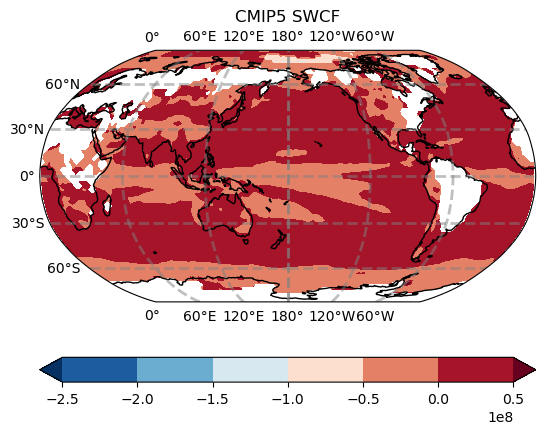

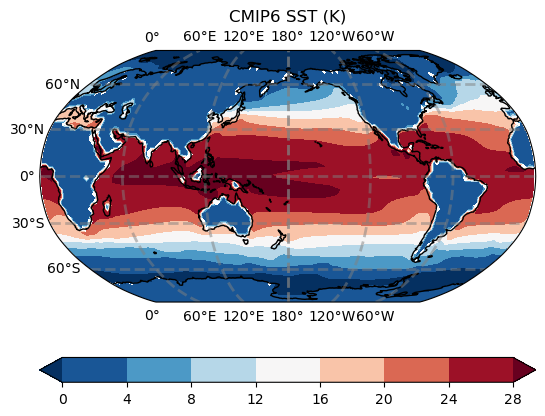

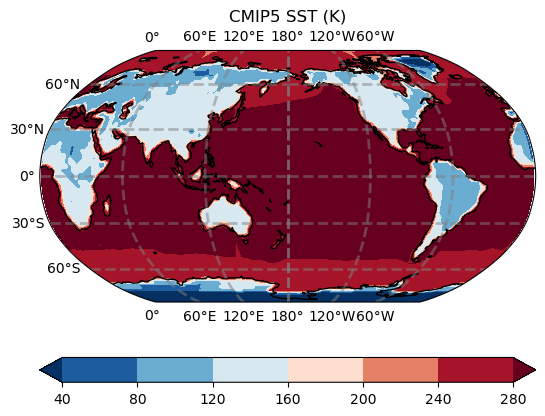

In [172]:
# Sanity check SWCF
# global_plot(lon=swcf_cmip6.lon, lat=swcf_cmip6.lat, data=swcf_cmip6.mean(["model"]), cmap="RdBu_r", title="CMIP6 SWCF")
# TODO: issue with cmip5 data
global_plot(lon=swcf_cmip5.lon, lat=swcf_cmip5.lat, data=swcf_cmip5.mean(["model"], skipna=True), cmap="RdBu_r", title="CMIP5 SWCF")

# Sanity check SWCRE
# global_plot(lon=swcre_cmip5.lon, lat=swcre_cmip5.lat, data=swcre_cmip5.mean(["model", "time"], skipna=True)["swcre"], cmap="RdBu_r", title="CMIP5 SWCRE")
# global_plot(lon=swcre_cmi6.lon, lat=swcre_cmi6.lat, data=swcre_cmi6.mean(["model", "time"], skipna=True)["swcre"], cmap="RdBu_r", title="CMIP6 SWCRE")

# Sanity check SSTs
global_plot(lon=tos_cmip6.lon, lat=tos_cmip6.lat, data=tos_cmip6.mean(["model", "time"], skipna=True)["tos"], cmap="RdBu_r", title="CMIP6 SST (K)")
global_plot(lon=tos_cmip5.lon, lat=tos_cmip5.lat, data=tos_cmip5.mean(["model", "time"], skipna=True)["tos"], cmap="RdBu_r", title="CMIP5 SST (K)")

# Sanity check linscope from xscore
# tos_test = tos_anoms_cmip6["tos"].sel(lat=0, lon=0, method="nearest").isel(model=1)
# swcre_test = swcre_anoms_cmip6["swcre_anoms"].sel(lat=0, lon=0, method="nearest").isel(model=1)

# tos_test = tos_test.chunk({'time': -1})
# swcre_test = swcre_test.chunk({'time': -1})

# print(linregress(tos_test.values, swcre_test.values))
# test = xscore.linslope(tos_test, swcre_test, dim='time', skipna=True)
# print(test.values)

In [90]:
# Calculate Rolling 30-year trend of SST gradient
tos_west_cmip6, tos_east_cmip6, tos_grad_cmip6 = calculate_west_east_gradient(ds=tos_cmip6, var="tos")
tos_west_cmip5, tos_east_cmip5, tos_grad_cmip5 = calculate_west_east_gradient(ds=tos_cmip5, var="tos")

tos_grad_cmip5 = tos_grad_cmip5.chunk({"time": -1})
tos_grad_cmip6 = tos_grad_cmip6.chunk({"time": -1})
tos_grad_trend_cmip6 = calculate_rolling_gradient(data=tos_grad_cmip6, window=30*12, step=12)
tos_grad_trend_cmip5 = calculate_rolling_gradient(data=tos_grad_cmip5, window=30*12, step=12)

tos_grad_trend_cmip5.to_netcdf("data/tos_grad_trend_cmip5.nc")
tos_grad_trend_cmip6.to_netcdf("data/tos_grad_trend_cmip6.nc")

IndexError: index 40 is out of bounds for axis 0 with size 40

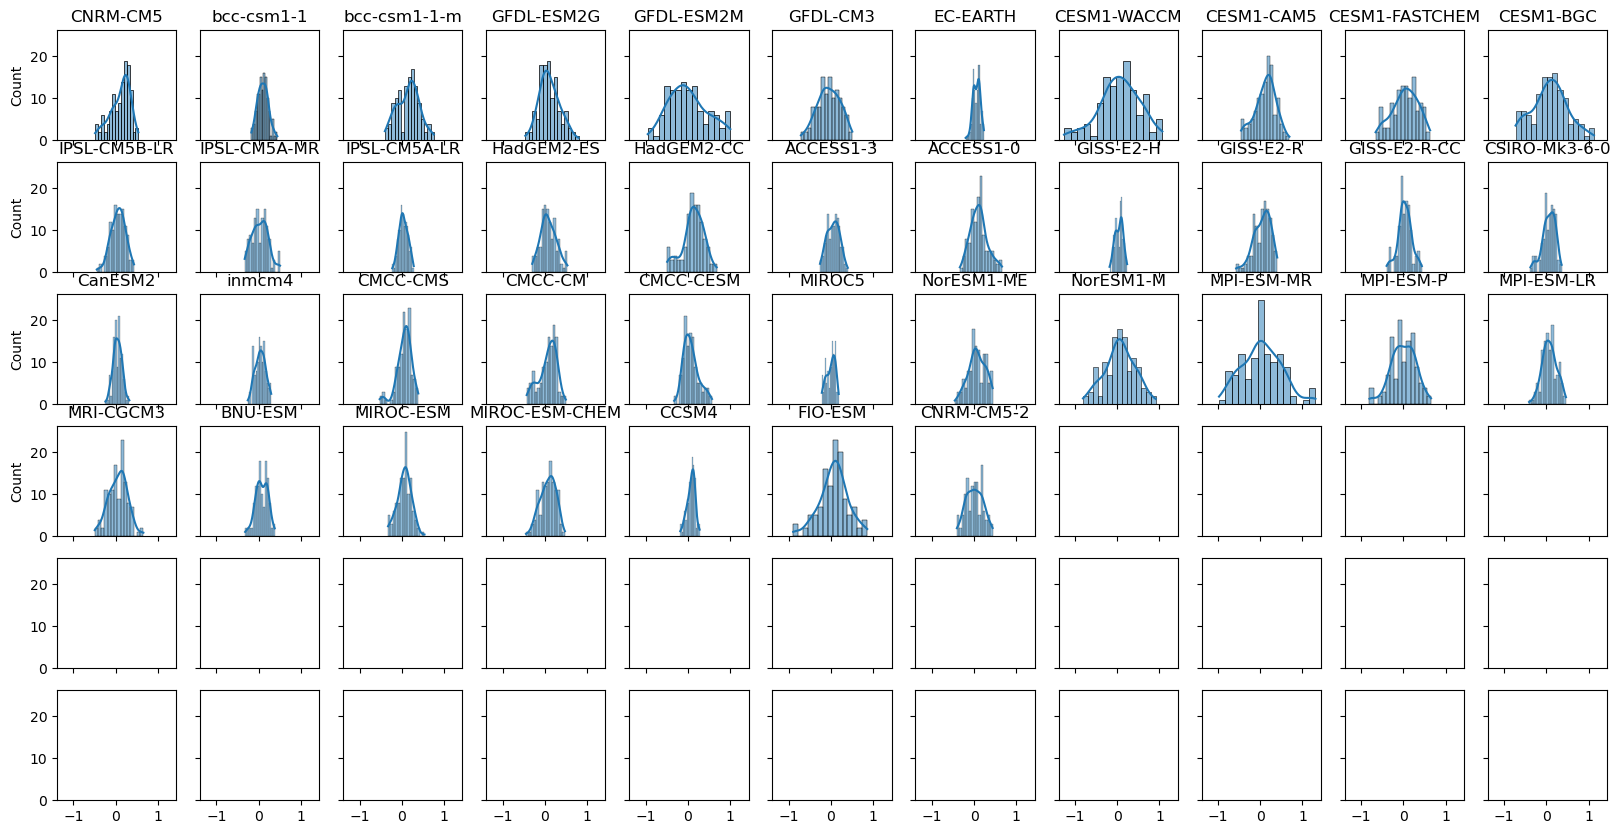

In [173]:
# Create a 2x2 figure and subplots
fig, axes = plt.subplots(6, 11, figsize=(20, 10),sharex=True, sharey=True)

# Create histograms using seaborn in each subplot
for i, ax in enumerate(axes.flatten()):
    if i == 40: break
    sns.histplot(tos_grad_trend_cmip5.isel(model=i), ax=ax, kde=True, bins=15)
    ax.set_title(tos_grad_trend_cmip5.model[i].values)

plt.xlabel("SST Gradient Trend (K/30yrs)")

# Analysis

In [184]:
# Load data
swcf_east_cmip6
tos_std = tos_grad_trend_cmip6.var("time")
tos_east_std = tos_east_cmip6.resample(time="5Y").mean("time").var("time")
print(tos_east_cmip6.resample(time="5Y").mean("time"))
# print(tos_east_cmip6.resample(time="5Y").mean("time"))
tos_west_std = tos_west_cmip6.var("time")


shared_models = list(set(swcf_east_cmip6.model.values) & set(tos_std.model.values))

<xarray.DataArray 'tos' (model: 61, time: 31)>
dask.array<transpose, shape=(61, 31), dtype=float64, chunksize=(25, 1), chunktype=numpy.ndarray>
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'E3SM-2-0' 'CanESM5-1'
  * time     (time) object 1850-12-31 00:00:00 ... 2000-12-31 00:00:00
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-10-28T20:27:47Z altered by CMOR: replaced missing va...
    regrid_method:  bilinear


In [181]:
def create_scatter(x, y, xlabel: str = "", ylabel: str = "", left_title: str = "", right_title: str ="") -> None:
    plt.scatter(x, y, s=10, color="black")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    plt.plot(x, x*slope+intercept, color="black", linestyle="-")
    
    plt.title(left_title, loc="left", fontweight="bold")
    plt.title(f"{right_title} (r={r},p={p})", loc="right", fontweight="bold")

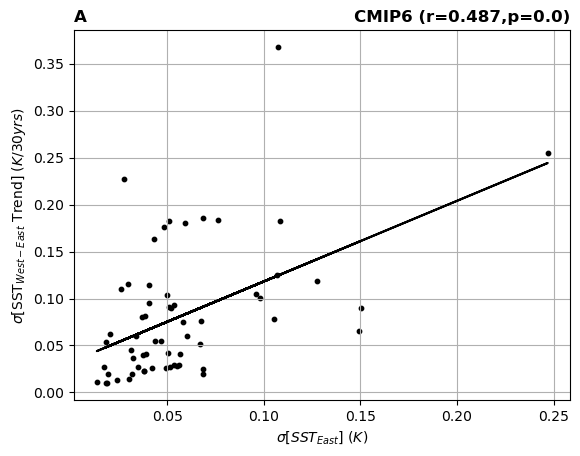

In [182]:
create_scatter(tos_east_std, tos_std, ylabel="$\sigma$[SST$_{West-East}$ Trend] ($K/30yrs$)", xlabel="$\sigma$[$SST_{East}$] ($K$)", left_title="A", right_title="CMIP6")

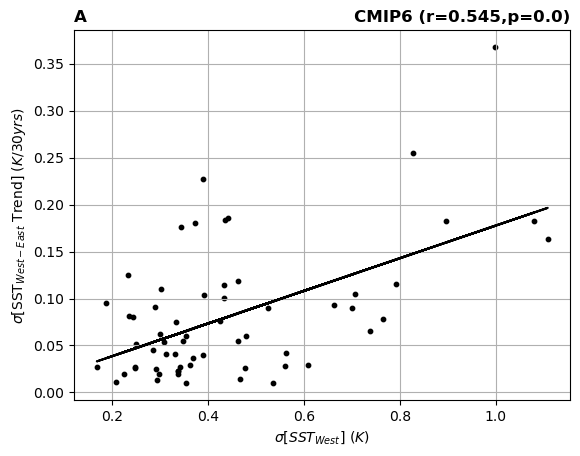

In [152]:
create_scatter(tos_west_std, tos_std, ylabel="$\sigma$[SST$_{West-East}$ Trend] ($K/30yrs$)", xlabel="$\sigma$[$SST_{West}$] ($K$)", left_title="A", right_title="CMIP6")

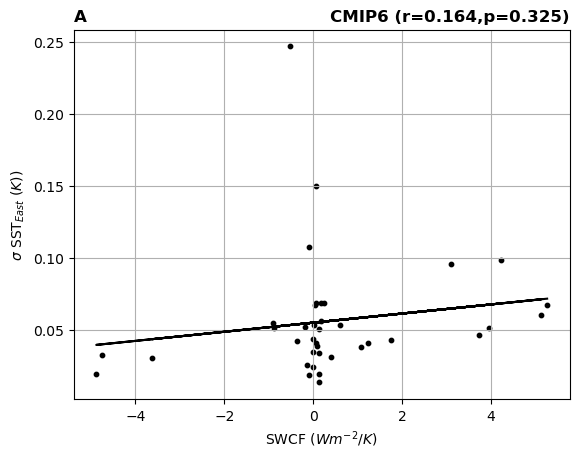

In [183]:
# shared_models = list(set(swcf_east_cmip6.model.values) & set(tos_std.model.values))
# swcf_east_cmip6_shared = swcf_east_cmip6.sel(model=shared_models)
# tos_east_std_shared = tos_east_std.sel(model=shared_models)
# mask = ~(np.isnan(swcf_east_cmip6_shared.values) | np.isnan(tos_east_std_shared.values))
create_scatter(x=swcf_east_cmip6_shared[mask], y=tos_east_std[mask], ylabel=r"$\sigma$ SST$_{East}$ ($K$))", xlabel=r"SWCF $(Wm^{-2}/K)$", left_title="A", right_title="CMIP6")

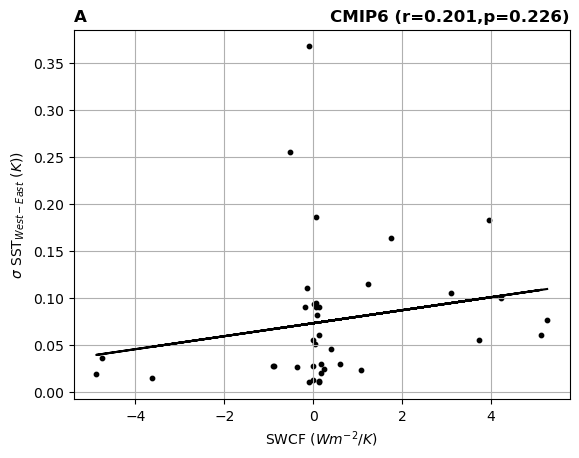

In [156]:
create_scatter(x=swcf_east_cmip6_shared[mask], y=tos_std[mask], ylabel=r"$\sigma$ SST$_{West-East}$ ($K$))", xlabel=r"SWCF $(Wm^{-2}/K)$", left_title="A", right_title="CMIP6")